In [1]:
import pandas as pd
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

/Users/admin/miniconda3/miniconda3/envs/ml/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
!ls archive

test.csv  train.csv


In [3]:
def getPath(path):
    BASE_PATH = "archive/"
    return BASE_PATH + path

In [4]:
orig_data = pd.read_csv(getPath("train.csv"))
data = orig_data

In [5]:
data.head()

,x,y
0,24.0,21.549452
1,50.0,47.464463
2,15.0,17.218656
3,38.0,36.586398
4,87.0,87.288984


In [6]:
def min_max_scaling(value, min_value, max_value):
    return (value - min_value) / (max_value - min_value)

def reverse_min_max_scaling(scaled_value, min_value, max_value):
    return (scaled_value * (max_value - min_value)) + min_value

def tanh_normalize(x, mean, std):
    return np.tanh((x - mean) / std)

### Analyzing Data

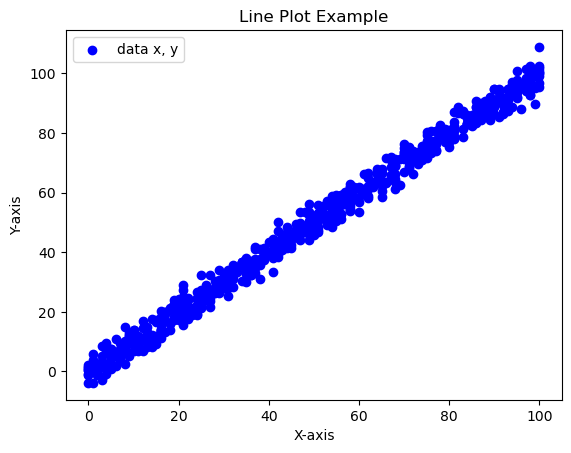

In [7]:
# Create a line plot
plt.scatter(data.x, data.y, label='data x, y', color='blue', marker='o')

# Add title and labels
plt.title('Line Plot Example')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add a legend
plt.legend()

# Show the plot
plt.show()

#### Data Cleaning

In [8]:
# scaling
# data.x = np.log10(data.x)
def describe(data):
    print("|describe|", data.describe())
    print("-------------Divider--------------")
    print("|info|", data.info())
    print("-------------Divider--------------")
    print("|NULL|", data.isna().sum())
describe(data)

|describe|                  x           y
count   700.000000  699.000000
mean     54.985939   49.939869
std     134.681703   29.109217
min       0.000000   -3.839981
25%      25.000000   24.929968
50%      49.000000   48.973020
75%      75.000000   74.929911
max    3530.157369  108.871618
-------------Divider--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       700 non-null    float64
 1   y       699 non-null    float64
dtypes: float64(2)
memory usage: 11.1 KB
|info| None
-------------Divider--------------
|NULL| x    0
y    1
dtype: int64


### Feature Engineering

In [9]:
# Drop Null Values
data = data.dropna()


In [10]:

### Min-Max Scaling
data.x = min_max_scaling(data.x, data.x.min(), data.x.max())
data.y = min_max_scaling(data.y, data.y.min(), data.y.max())

# data.x = tanh_normalize(data.x, data.x.mean(), data.x.std())
# data.y = tanh_normalize(data.y, data.y.mean(), data.y.std())

data

/var/folders/pb/g2k3gt9d0y3flmhl3h6j21dm0000gn/T/ipykernel_7146/2641670216.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.x = min_max_scaling(data.x, data.x.min(), data.x.max())
/var/folders/pb/g2k3gt9d0y3flmhl3h6j21dm0000gn/T/ipykernel_7146/2641670216.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.y = min_max_scaling(data.y, data.y.min(), data.y.max())


,x,y
0,0.24,0.225260
1,0.50,0.455183
2,0.15,0.186836
3,0.38,0.358671
4,0.87,0.808515
...,...,...
695,0.58,0.553936
696,0.93,0.873602
697,0.82,0.820180
698,0.66,0.598773


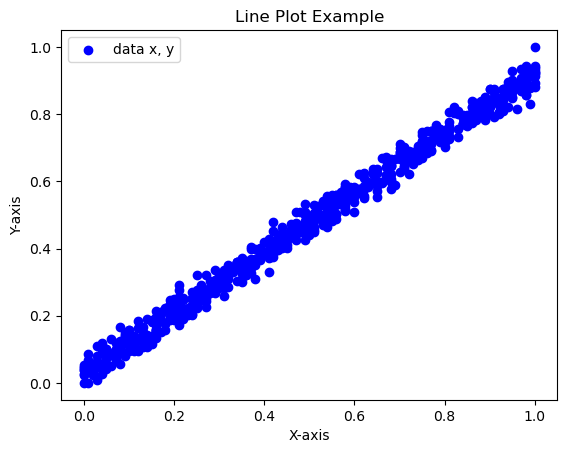

In [11]:
# Create a line plot
plt.scatter(data.x, data.y, label='data x, y', color='blue', marker='o')

# Add title and labels
plt.title('Line Plot Example')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add a legend
plt.legend()

# Show the plot
plt.show()

### Train Model

##### Splitting the dataset

In [12]:
X = data.drop(columns=['y'])
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Forward Pass
class LinearRegression():
    def __init__(self, learning_rate=0.001):
        self.learning_rate = learning_rate
        self.weights = torch.tensor([0.001], requires_grad=True)
        self.bias = torch.tensor([0.001], requires_grad=True)

    def __numpy_to_tensor(self, data):
        return torch.Tensor(data.to_numpy())

    def __forward_pass(self, data):
        return torch.sum(data * self.weights + self.bias, dim=1)

    def fit(self, data, ground_truth):  
        data = self.__numpy_to_tensor(data) # cast to tensor
        ground_truth = self.__numpy_to_tensor(ground_truth) # cast to tensor
        
        # Forward pass
        predictions = self.__forward_pass(data)
    
        # Loss
        loss = torch.sum((predictions - ground_truth) ** 2)
    
        # Backward Pass
        loss.backward()
    
        # Nudge the gradients
        with torch.no_grad():
            self.weights -= self.learning_rate * self.weights.grad
    
        # Reset Gradients
        self.weights.grad.zero_()

        print(loss) # TODO remove

    def predict(self, data):
        data = self.__numpy_to_tensor(data) # cast to tensor
        return self.__forward_pass(data).detach().numpy()

    # print(data)
    # print(ground_truth)
    # print(predictions)



model = LinearRegression()
model.fit(X_train, y_train)

tensor(169.9195, grad_fn=<SumBackward0>)


In [25]:
# from sklearn.linear_model import LinearRegression
# model = LinearRegression()
# model.fit(X_train, y_train)

# model.coef_

### Evaluating Model

In [26]:
# ## Predict the target variable (y) using the test set
print(type(X_test))
y_pred = model.predict(X_test)

#### TODO implement mean_squared_error && r2_score

# ## Evaluate the model 
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print("Mean Squared Error:", mse)
# print("R-squared:", r2)

<class 'pandas.core.frame.DataFrame'>


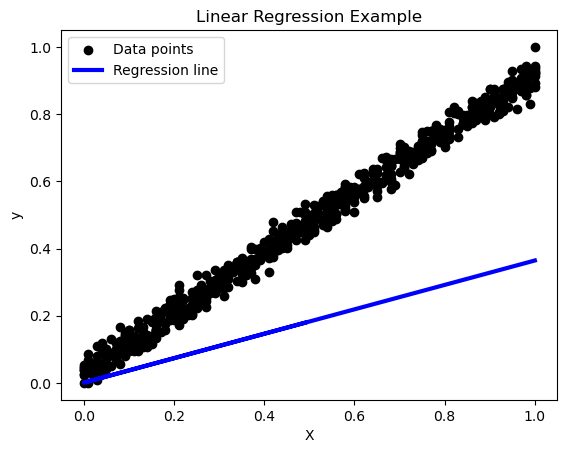

In [27]:
# Plot model
plt.scatter(data.x, data.y, color='black', label='Data points')
plt.plot(X_test, y_pred, color='blue', linewidth=3, label='Regression line')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression Example')
plt.legend()
plt.show()

### Test

|describe|                 x           y
count  300.000000  300.000000
mean    50.936667   51.205051
std     28.504286   29.071481
min      0.000000   -3.467884
25%     27.000000   25.676502
50%     53.000000   52.170557
75%     73.000000   74.303007
max    100.000000  105.591837
-------------Divider--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       300 non-null    int64  
 1   y       300 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.8 KB
|info| None
-------------Divider--------------
|NULL| x    0
y    0
dtype: int64


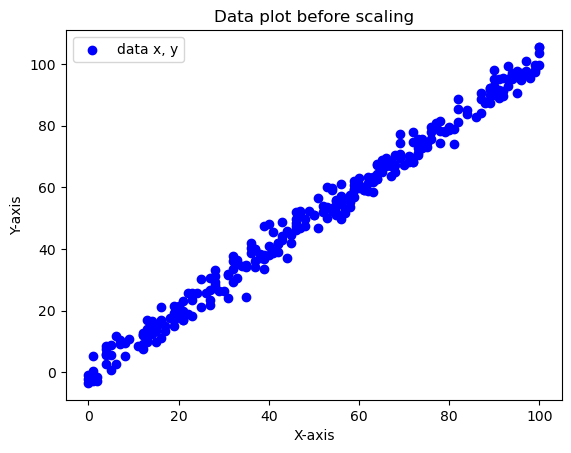

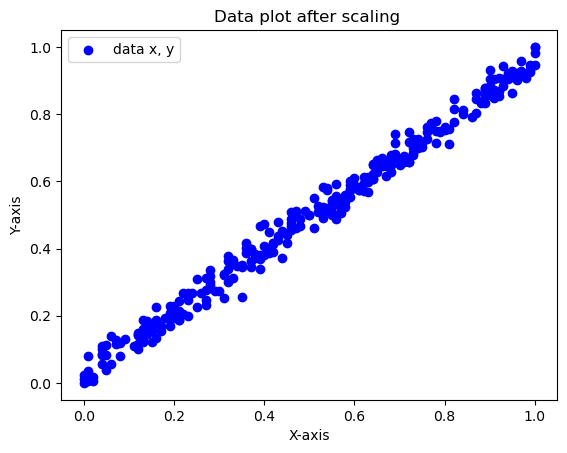

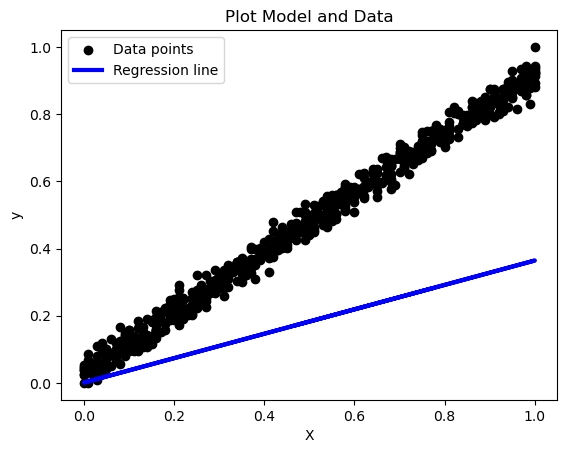

Mean Squared Error: 0.12613687437741875
R-squared: -0.7810929690682904
      x          y     y_pred       diff
0    77  79.775152  27.156719 -52.618433
1    21  23.177279   4.963597 -18.213682
2    22  25.609262   5.359903 -20.249358
3    20  17.857388   4.567291 -13.290097
4    36  41.849864  10.908184 -30.941680
..   ..        ...        ...        ...
295  71  68.545888  24.778883 -43.767005
296  46  47.334876  14.871243 -32.463634
297  55  54.090637  18.437994 -35.652643
298  62  63.297171  21.212135 -42.085035
299  47  52.459467  15.267548 -37.191919

[300 rows x 4 columns]


In [28]:
def test():
    orig_test = pd.read_csv(getPath("test.csv"))
    test = orig_test.copy()

    describe(test)

    # Data plot before scaling
    plt.scatter(test.x, test.y, label='data x, y', color='blue', marker='o')
    plt.title('Data plot before scaling')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.show()

    ### Min-Max Scaling
    test.x = min_max_scaling(orig_test.x, orig_test.x.min(), orig_test.x.max())
    test.y = min_max_scaling(orig_test.y, orig_test.y.min(), orig_test.y.max())

    # Data plot after scaling 
    plt.scatter(test.x, test.y, label='data x, y', color='blue', marker='o')
    plt.title('Data plot after scaling ')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.show()

    # Predict
    X_test = test.drop(columns=['y'])
    y_ground_truth = test['y']
    y_pred = model.predict(X_test)

    # Plot model
    plt.scatter(data.x, data.y, color='black', label='Data points')
    plt.plot(X_test, y_pred, color='blue', linewidth=3, label='Regression line')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('Plot Model and Data')
    plt.legend()
    plt.show()

    # Mean squared Error and R-Squared÷
    mse = mean_squared_error(y_ground_truth, y_pred)
    r2 = r2_score(y_ground_truth, y_pred)
    print("Mean Squared Error:", mse)
    print("R-squared:", r2)

    y_pred = reverse_min_max_scaling(y_pred, orig_test.y.min(), orig_test.y.max())
    result = pd.DataFrame({ 'x': orig_test.x, 'y': orig_test.y, 'y_pred': y_pred, 'diff': y_pred - orig_test.y })
    print(result)
    

test()